# Predicting Pokemon Types from Images and Statistics

Scott Ratchford, (c) 2025

See `LICENSE.txt` for license information.

## Setup

### Constants and Parameters

In [1]:
# Set paths to data files and directories

import os
import pandas as pd
import numpy as np

CWD = os.getcwd()

# Input paths for data (modify as required)
# PKMN_IMG_ALT_DIR = os.path.join(CWD, "data", "pokemon_images_alt", "images")                    # Directory containing all Pokemon images
POKEDEX_ALT_PATH = os.path.join(CWD, "data", "pokemon_images_alt", "pokedex_alt_modified.csv")  # .csv file from "Pokemon with Stats and Images"
PKMN_STATS_PATH = os.path.join(CWD, "data", "pokemon_stats.csv")                                # .csv file from "Pokemon Pokedex"

# Output paths for created and modified data (modify as required)
PKMN_IMG_COLORS_ALT_PATH = os.path.join(CWD, "pokemon_colors_alt.csv")              # Pokemon color data output
PKMN_IMG_COLORS_ALT_TRAIN_PATH = os.path.join(CWD, "pokemon_colors_alt_train.csv")  # Pokemon color training data output
PKMN_IMG_COLORS_ALT_TEST_PATH = os.path.join(CWD, "pokemon_colors_alt_test.csv")    # Pokemon color testing data output

# Set Pokemon image input and output paths
DATASET_DIR = os.path.join(CWD, "data", "pokemon_images", "dataset")
TRAIN_IMG_DIR = os.path.join(CWD, "data", "pokemon_images", "train_images")
TEST_IMG_DIR = os.path.join(CWD, "data", "pokemon_images", "test_images")

RNG_SEED = 151

### Import Datasets

In [2]:
# Import in-game statistics dataset
pkmn_stats = pd.read_csv(POKEDEX_ALT_PATH, encoding="utf-8")
pkmn_stats["Name"] = pkmn_stats["Name"].apply(lambda x: x.lower())
print(f"PKMN stats rows: {pkmn_stats.shape[0]}")
print(f"PKMN stats columns: {list(pkmn_stats.columns)}")

# Import image colors dataset
pkmn_color_df = pd.read_csv(PKMN_IMG_COLORS_ALT_PATH, encoding="utf-8", index_col=0)
print(f"PKMN color rows: {pkmn_color_df.shape[0]}")
print(f"PKMN colors columns: {list(pkmn_color_df.columns)}")

# Add Number and Train columns to pkmn_stats
pkmn_stats = pd.merge(pkmn_stats, pkmn_color_df[["Name", "Number", "Train"]], on=["Name", ], how="inner")

PKMN stats rows: 1215
PKMN stats columns: ['Index', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense', 'SP. Atk.', 'SP. Def', 'Speed', 'Ignore', 'Filename']
PKMN color rows: 959
PKMN colors columns: ['Name', 'Type 1', 'Type 2', 'Filename', 'Number', 'Train', 'black', 'blue', 'pink', 'green', 'purple', 'red', 'white', 'yellow', 'orange']


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Drop columns that provide too much or unneeded information about the Pokemon
drop_cols = ["Name", "Ignore", "Type 2", "Filename", "Number", ]
target_cols = ["Type 1", ]

# Encode type strings (to ints)
type_label_encoder = LabelEncoder()
pkmn_stats["Type 1"] = type_label_encoder.fit_transform(pkmn_stats["Type 1"])
pkmn_stats["Type 1"] = pkmn_stats["Type 1"].astype(dtype=int)
# pkmn_stats["Type 2"] = type_label_encoder.fit_transform(pkmn_stats["Type 2"])
# pkmn_stats["Type 2"] = pkmn_stats["Type 2"].astype(dtype=int)

pkmn_stats_train = pkmn_stats[pkmn_stats["Train"] == True]
pkmn_stats_train = pkmn_stats_train.drop(labels=["Train", ], axis=1)
pkmn_stats_test = pkmn_stats[pkmn_stats["Train"] == False]
pkmn_stats_test = pkmn_stats_test.drop(labels=["Train", ], axis=1)

X_train = pkmn_stats_train.drop(labels=(drop_cols + target_cols), axis=1)
y_train = pkmn_stats_train[target_cols]
X_test = pkmn_stats_test.drop(labels=(drop_cols + target_cols), axis=1)
y_test = pkmn_stats_test[target_cols]

print("Split Pokemon statistics into training and testing.")

Split Pokemon statistics into training and testing.


## Single-Label Type Classification Based on In-Game Statistics

These models use in-game statistics to predict the value of `Type 1`.

### K-Nearest Neighbors

In [4]:
# Create the KNN model for in-game statistics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_stats_model = KNeighborsClassifier()
# hyperparameters to try
knn_hyperparameters = {
    "n_neighbors": range(3, 11),
    "leaf_size": range(10, 41),
    "p": range(1, 4),
    "weights": ("distance", "uniform", ),
    "algorithm": ("kd_tree", "ball_tree", ),
}

knn_clf = GridSearchCV(knn_stats_model, knn_hyperparameters, n_jobs=-1)

knn_stats_model = knn_clf.fit(X_train, y_train.values.ravel())

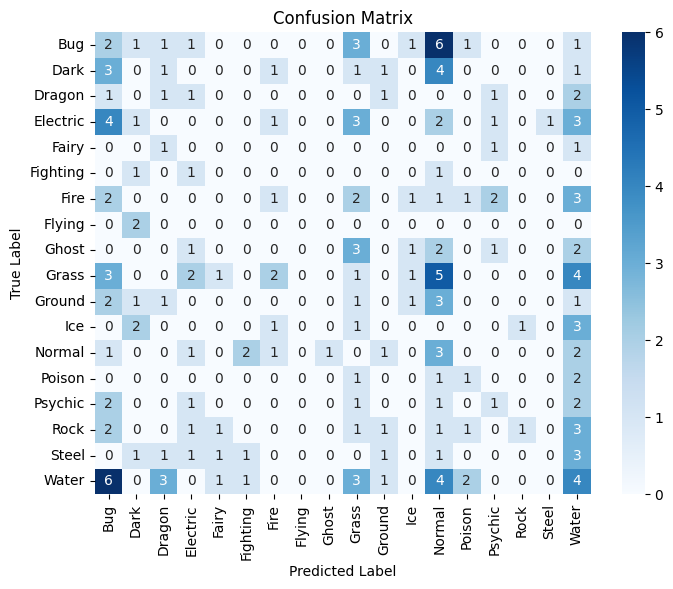

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

knn_stats_pred = knn_clf.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, knn_stats_pred)

# Get the unique encoded labels from the true labels
labels_encoded = np.unique(y_test)
# Use the previously defined and fitted type_label_encoder to decode labels
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap visualization with the decoded labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Single-Label Type Classification Based on Image Colors

### Load Pokemon Color Data from Files

In [6]:
pkmn_color_df = pd.read_csv(PKMN_IMG_COLORS_ALT_PATH, sep=",", encoding="utf-8", index_col=0)

pkmn_color_train_df = pkmn_color_df[pkmn_color_df["Train"] == True]
pkmn_color_test_df = pkmn_color_df[pkmn_color_df["Train"] == False]

print(f"Color data for {pkmn_color_train_df.shape[0]} testing Pokemon loaded.")
print(f"Color data for {pkmn_color_test_df.shape[0]} testing Pokemon loaded.")

Color data for 767 testing Pokemon loaded.
Color data for 192 testing Pokemon loaded.


In [7]:
def sample_min_entries(df: pd.DataFrame, target_col: str, min_entries: int, random_state=42):
    """
    Returns a new DataFrame containing a random subset such that
    each unique value in target_col is represented with at least min_entries entries,
    or all entries if there are less than min_entries available.
    
    Parameters:
    - df: Original DataFrame.
    - min_entries: Minimum number of entries to sample from each group.
    - random_state: Seed for reproducibility.
    """
    # Group by target_col and sample n=min(len(group), min_entries) rows from each group.
    return df.groupby(target_col, group_keys=False).apply(
        lambda group: group.sample(n=min(len(group), min_entries), random_state=random_state), include_groups=True
    )

### Adjust Data to Reduce Class Bias

Pokemon types (classes) are not present in equal quantities. Some types, like Water and Normal, are far more abundant than types like Dragon and Steel. To reduce the impact of this disparity on the data set, instances of underrepresented classes are duplicated and instances of overrepresented classes are dropped to achieve equal class representations within the data sets.

In [8]:
def reduce_bias(df: pd.DataFrame, label_col: str) -> tuple[pd.DataFrame, int]:
    # Compute the counts of each class in label_col
    class_counts = df[label_col].value_counts()

    # Identify and print the most and least represented classes
    most_class = class_counts.max()
    least_class = class_counts.min()

    # Compute the median number of rows per class
    median_count = int(np.median(class_counts.values))

    # Create a list to hold the balanced DataFrames for each class
    balanced_dfs = []

    # Process each class separately
    for class_val, count in class_counts.items():
        # Select rows for the current class and reset index to preserve order
        df_class = df[df[label_col] == class_val].reset_index(drop=True)
        # If there are too many rows, drop the extra ones by taking only the first median_count rows.
        if count > median_count:
            df_balanced = df_class.iloc[:median_count]
        # Duplicate rows to reach median_count
        elif count < median_count:
            # Calculate how many extra rows are needed
            diff = median_count - count
            # Determine how many times to duplicate each row and the remainder
            q, r = divmod(diff, count)

            # Create a list to hold the rows (as Series) in the desired order
            rows_list = []
            for i in range(count):
                row = df_class.iloc[i]
                # Always add the original row
                rows_list.append(row)
                # Duplicate each row q times
                for _ in range(q):
                    rows_list.append(row)
                # For the first r rows, add one additional duplicate
                if i < r:
                    rows_list.append(row)
            
            df_balanced = pd.DataFrame(rows_list)
            df_balanced.reset_index(drop=True, inplace=True)
        # If the number of rows equals the median, keep as is
        else:
            df_balanced = df_class
        
        # Append the balanced DataFrame for this class to the list
        balanced_dfs.append(df_balanced)

    # Concatenate all the balanced DataFrames to form the final DataFrame
    df_balanced_final = pd.concat(balanced_dfs).reset_index(drop=True)

    return df_balanced_final, median_count

In [9]:
pkmn_color_train_df_unbiased, train_med = reduce_bias(pkmn_color_train_df, "Type 1")
pkmn_color_test_df_unbiased, test_med = reduce_bias(pkmn_color_test_df, "Type 1")

print(f"Adjusted training dataset to include exactly {train_med} of each type.")
print(f"Adjusted testing dataset to include exactly {test_med} of each type.")

Adjusted training dataset to include exactly 33 of each type.
Adjusted testing dataset to include exactly 10 of each type.


### Label and Scale Data

In [10]:
drop_color_cols = []
# Drop columns that provide too much information about the Pokemon
drop_color_cols.extend(["Name", "Number", "Filename", ])
# Drop other columns
drop_color_cols.extend(["Type 2", "Train", ])
# Drop columns containing target information
drop_color_cols.extend(["Type 1", ])

type_label_encoder = LabelEncoder()

#### Original Data

Label the data that **was not** passed through `reduce_bias()`.

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

X_colors_train_original = pkmn_color_train_df.drop(labels=drop_color_cols, axis=1)
X_colors_test_original = pkmn_color_test_df.drop(labels=drop_color_cols, axis=1)
y_colors_train_original = pkmn_color_train_df[["Type 1"]].copy()
y_colors_test_original = pkmn_color_test_df[["Type 1"]].copy()

# Encode type strings to ints
y_colors_train_original["Type 1"] = type_label_encoder.fit_transform(y_colors_train_original["Type 1"])
y_colors_train_original["Type 1"] = y_colors_train_original["Type 1"].astype(dtype=int)
y_colors_test_original["Type 1"] = type_label_encoder.fit_transform(y_colors_test_original["Type 1"])
y_colors_test_original["Type 1"] = y_colors_test_original["Type 1"].astype(dtype=int)

#### Unbiased Data

Label the data that **was** passed through `reduce_bias()`.

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

X_colors_train_unbiased = pkmn_color_train_df_unbiased.drop(labels=drop_color_cols, axis=1)
X_colors_test_unbiased = pkmn_color_test_df_unbiased.drop(labels=drop_color_cols, axis=1)
y_colors_train_unbiased = pkmn_color_train_df_unbiased[["Type 1"]].copy()
y_colors_test_unbiased = pkmn_color_test_df_unbiased[["Type 1"]].copy()

# Encode type strings to ints
y_colors_train_unbiased["Type 1"] = type_label_encoder.fit_transform(y_colors_train_unbiased["Type 1"])
y_colors_train_unbiased["Type 1"] = y_colors_train_unbiased["Type 1"].astype(dtype=int)
y_colors_test_unbiased["Type 1"] = type_label_encoder.fit_transform(y_colors_test_unbiased["Type 1"])
y_colors_test_unbiased["Type 1"] = y_colors_test_unbiased["Type 1"].astype(dtype=int)

### Pokemon Colors KNN

Because sklearn's k-nearest neighbors functions do not support modifying class weights, this k-nearest neighbors classifier uses the Pokemon color data adjusted by `reduce_bias()`.

#### KNN Training

In [13]:
# Create the KNN model for colors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_colors_model = KNeighborsClassifier()
# hyperparameters to try
knn_hyperparameters = {
    "n_neighbors": range(3, 31),
    "leaf_size": range(10, 51, 5),
    "p": range(1, 4),
    "weights": ("distance", "uniform", ),
    "algorithm": ("kd_tree", "ball_tree", ),
    "metric": ("minkowski", "chebyshev", ),
}

knn_colors_clf = GridSearchCV(knn_colors_model, knn_hyperparameters, n_jobs=-1)
knn_colors_model = knn_colors_clf.fit(X_colors_train_unbiased, y_colors_train_unbiased.values.ravel())

print(knn_colors_clf.best_params_)

{'algorithm': 'kd_tree', 'leaf_size': 10, 'metric': 'chebyshev', 'n_neighbors': 29, 'p': 1, 'weights': 'distance'}


#### KNN Evaluation

In [14]:
from sklearn.metrics import accuracy_score

knn_color_pred = knn_colors_clf.predict(X_colors_test_unbiased)

accuracy = accuracy_score(y_colors_test_unbiased, knn_color_pred)
print(f"Accuracy: {accuracy:.4f}, Test Error: {1-accuracy:.4f}")
print(f"{accuracy * y_colors_test_unbiased.shape[0]:.0f} out of {y_colors_test_unbiased.shape[0]} correctly predicted")

Accuracy: 0.1778, Test Error: 0.8222
32 out of 180 correctly predicted


In [15]:
from IPython.display import display, HTML

accuracy = accuracy_score(y_colors_test_unbiased, knn_color_pred)
knn_color_eval = y_colors_test_unbiased.copy()
knn_color_eval["Predicted Type"] = knn_color_pred

knn_color_eval["Type 1"] = type_label_encoder.inverse_transform(knn_color_eval["Type 1"])
knn_color_eval["Predicted Type"] = type_label_encoder.inverse_transform(knn_color_eval["Predicted Type"])

knn_color_eval = pd.merge(knn_color_eval, pkmn_color_test_df_unbiased.drop(["Type 1", ], axis=1), how="inner", left_index=True, right_index=True)
knn_color_eval["Correct"] = knn_color_eval.apply(lambda row: row["Predicted Type"] in (row["Type 1"], row["Type 2"]), axis=1)

# Compute the overall accuracy.
either_accuracy = knn_color_eval["Correct"].mean()
print(f"Either type accuracy: {either_accuracy:.4f}")

Either type accuracy: 0.1944


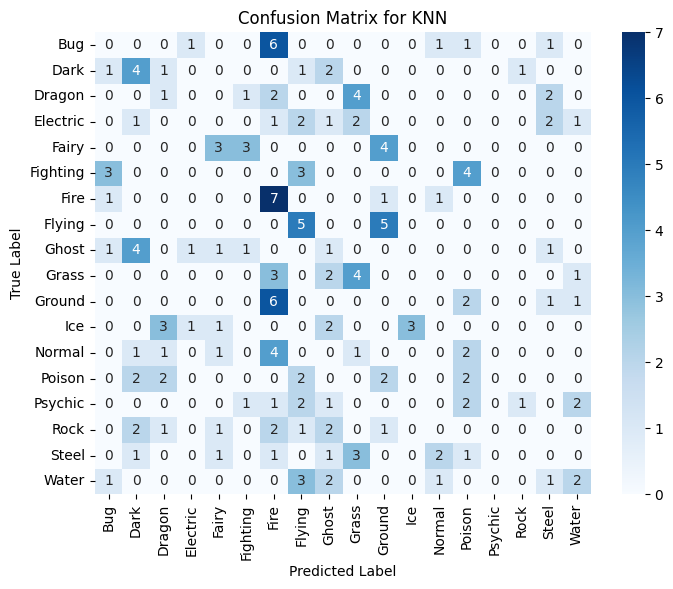

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_colors_test_unbiased, knn_color_pred)

# Get the unique encoded labels from the true labels
labels_encoded = np.unique(y_colors_test_unbiased)
# Use the previously defined and fitted type_label_encoder to decode labels
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap visualization with the decoded labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN')
plt.show()

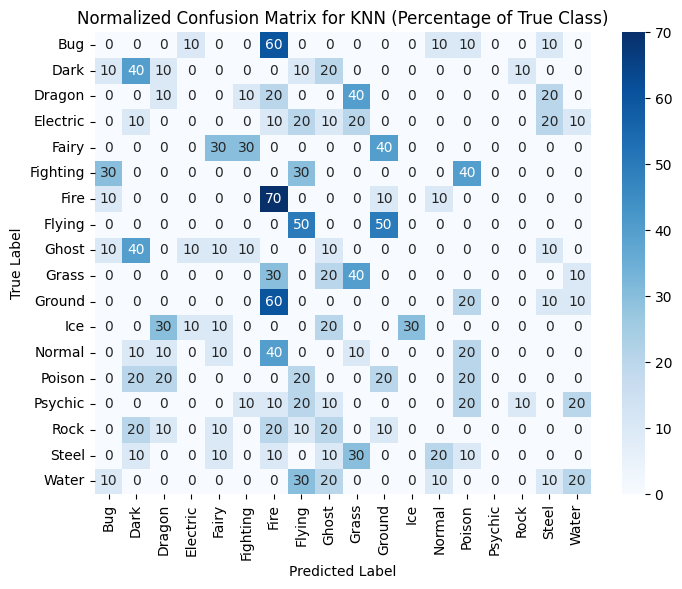

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_colors_test_unbiased, knn_color_pred)

# Normalize the confusion matrix by the true labels (i.e. each row)
cm_normalized = cm.astype(int) / cm.sum(axis=1)[:, np.newaxis]

# Retrieve the original class labels using the fitted label encoder
labels_encoded = np.unique(y_colors_test_unbiased)
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap using the normalized percentages (multiplied by 100)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized * 100, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix for KNN (Percentage of True Class)')
plt.show()

### Pokemon Colors RF

Because sklearn's random forest functions support modifying class weights, this random forest classifier uses the original Pokemon color data.

#### RF Training

In [ ]:
# Create the KNN model for colors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# hyperparameters to try
rf_hyperparameters = {
    "criterion": ['gini', ],    # 'entropy', 'log_loss'
    "n_estimators": range(100, 1050, 50),
    "min_samples_split": range(2, 12, 2),
    "max_depth": list(range(10, 45, 5)) + [None, ],
    "class_weight": ["balanced", ], # "balanced_subsample", 
    "random_state": (RNG_SEED, ),
}

rf_colors_clf = GridSearchCV(RandomForestClassifier(), rf_hyperparameters, n_jobs=-1)
rf_colors_clf = rf_colors_clf.fit(X_colors_train_original, y_colors_train_original.values.ravel())

print(rf_colors_clf.best_params_)

rf_colors_model = rf_colors_clf.best_estimator_

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 550, 'random_state': 151}


#### RF Evaluation

In [19]:
from sklearn.metrics import accuracy_score

rf_color_pred = rf_colors_clf.predict(X_colors_test_original)

accuracy = accuracy_score(y_colors_test_original, rf_color_pred)
print(f"Accuracy: {accuracy:.4f}, Test Error: {1-accuracy:.4f}")
print(f"{accuracy * y_colors_test_original.shape[0]:.0f} out of {y_colors_test_original.shape[0]} correctly predicted")

Accuracy: 0.2500, Test Error: 0.7500
48 out of 192 correctly predicted


In [20]:
accuracy = accuracy_score(y_colors_test_original, rf_color_pred)
rf_color_eval = y_colors_test_original.copy()
rf_color_eval["Predicted Type"] = rf_color_pred

rf_color_eval["Type 1"] = type_label_encoder.inverse_transform(rf_color_eval["Type 1"])
rf_color_eval["Predicted Type"] = type_label_encoder.inverse_transform(rf_color_eval["Predicted Type"])

rf_color_eval = pd.merge(rf_color_eval, pkmn_color_test_df.drop(["Type 1", ], axis=1), how="inner", left_index=True, right_index=True)
rf_color_eval["Correct"] = rf_color_eval.apply(lambda row: row["Predicted Type"] in (row["Type 1"], row["Type 2"]), axis=1)

# Compute the overall accuracy.
either_accuracy = rf_color_eval["Correct"].mean()
print(f"Either type accuracy: {either_accuracy:.4f}")

Either type accuracy: 0.2812


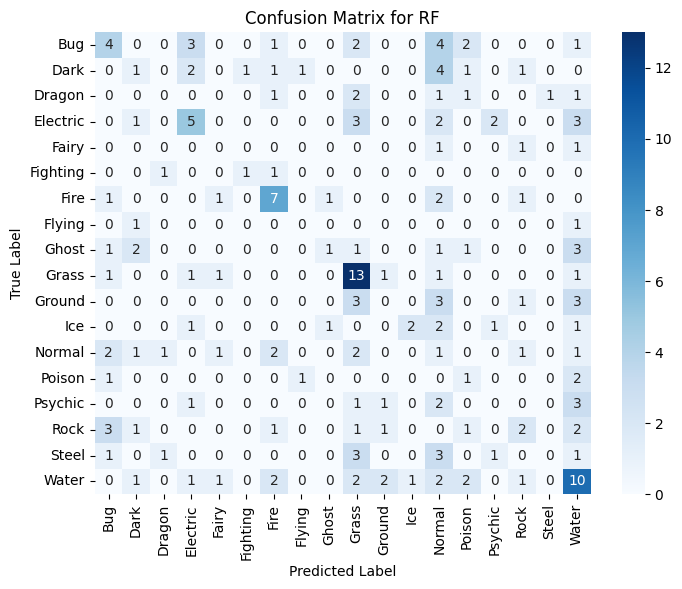

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_colors_test_original, rf_color_pred)

# Get the unique encoded labels from the true labels
labels_encoded = np.unique(y_colors_test_original)
# Use the previously defined and fitted type_label_encoder to decode labels
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap visualization with the decoded labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RF')
plt.show()

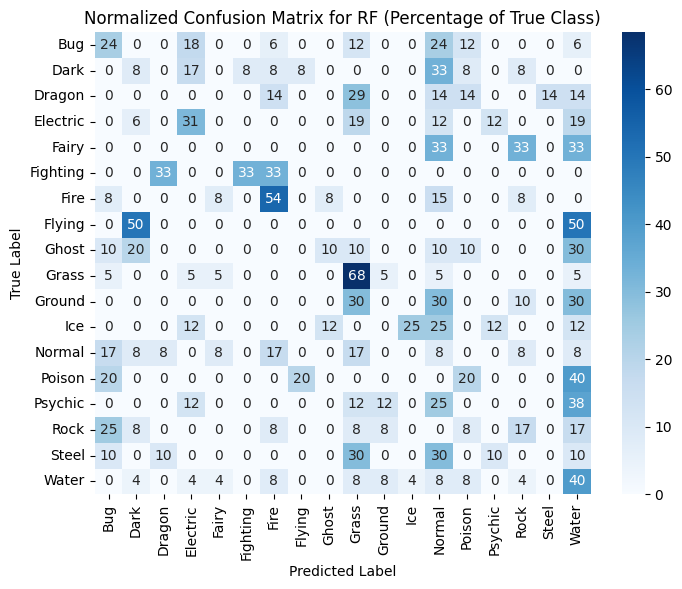

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_colors_test_original, rf_color_pred)

# Normalize the confusion matrix by the true labels (i.e. each row)
cm_normalized = cm.astype(int) / cm.sum(axis=1)[:, np.newaxis]

# Retrieve the original class labels using the fitted label encoder
labels_encoded = np.unique(y_colors_test_original)
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap using the normalized percentages (multiplied by 100)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized * 100, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix for RF (Percentage of True Class)')
plt.show()

## Multi-Label Type Classification Based on Image Colors

### Helper Functions

In [23]:
def either_correct(pred: tuple[str, str], true: tuple[str, str]) -> bool:
    for p in pred:
        if p in true:
            return True
    
    return False

def all_correct(pred: tuple[str, str], true: tuple[str, str]) -> bool:
    if len(pred) != 2 or len(true) != 2:
        raise ValueError("Length of pred and true must each be 2.")
    
    return set(pred).intersection(set(true)) == set(pred)

def either_accuracy_score(pred: pd.DataFrame, true: pd.DataFrame) -> float:
    df = pd.merge(pred, true, how="left", left_index=True, right_index=True)
    print(df.columns)
    df["either"] = df.apply(lambda x: either_correct((x["Type 1"], x["Type 2"]), (x["Type 1 Pred"], x["Type 2 Pred"])), axis=1)

    return df["either"].mean()

def both_accuracy_score(pred: pd.DataFrame, true: pd.DataFrame) -> float:
    df = pd.merge(pred, true, how="left", left_index=True, right_index=True)
    df["both"] = df.apply(lambda x: all_correct((x["Type 1"], x["Type 2"]), (x["Type 1 Pred"], x["Type 2 Pred"])), axis=1)

    return df["both"].mean()

### Load Image Colors with Type 1 and Type 2

In [24]:
pkmn_color_multitype_df = pd.read_csv(PKMN_IMG_COLORS_ALT_PATH, sep=",", encoding="utf-8", index_col=0)

pkmn_color_train_multitype_df = pkmn_color_multitype_df[pkmn_color_multitype_df["Train"] == True]
pkmn_color_test_multitype_df = pkmn_color_multitype_df[pkmn_color_multitype_df["Train"] == False]

print(f"Color data for {pkmn_color_train_df.shape[0]} testing Pokemon loaded.")
print(f"Color data for {pkmn_color_test_df.shape[0]} testing Pokemon loaded.")

Color data for 767 testing Pokemon loaded.
Color data for 192 testing Pokemon loaded.


In [25]:
drop_color_cols = []
# Drop columns that provide too much information about the Pokemon
drop_color_cols.extend(["Name", "Number", "Filename", ])
# Drop other columns
drop_color_cols.extend(["Train", ])
# Drop columns containing target information
drop_color_cols.extend(["Type 1", "Type 2", ])

In [26]:
from sklearn.preprocessing import StandardScaler

X_colors_train_multitype = pkmn_color_train_multitype_df.drop(labels=drop_color_cols, axis=1)
X_colors_test_multitype = pkmn_color_test_multitype_df.drop(labels=drop_color_cols, axis=1)
y_colors_train_multitype = pkmn_color_train_multitype_df[["Type 1", "Type 2", ]].copy()
y_colors_test_multitype = pkmn_color_test_multitype_df[["Type 1", "Type 2", ]].copy()

# Change NaN values to "None"
y_colors_train_multitype["Type 2"] = y_colors_train_multitype["Type 2"].apply(lambda x: x if pd.notna(x) else "None")
y_colors_test_multitype["Type 2"] = y_colors_test_multitype["Type 2"].apply(lambda x: x if pd.notna(x) else "None")

# Scale color data
color_cols = [
    'black', 'blue', 'pink', 'green', 'purple', 'red', 'white', 'yellow', 'orange',
]
scaler = StandardScaler()
X_colors_train_multitype[color_cols] = scaler.fit_transform(X_colors_train_multitype[color_cols])
X_colors_test_multitype[color_cols] = scaler.fit_transform(X_colors_test_multitype[color_cols])

### Random Forest with Multilabel Classification

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
rf_multi_hyperparameters = {
    "criterion": ['gini', ],    # 'entropy', 'log_loss'
    "n_estimators": range(100, 500, 100),
    "min_samples_split": range(2, 8, 2),
    "max_depth": list(range(10, 25, 5)) + [None, ],
    "class_weight": ["balanced", "balanced_subsample", ],
    "random_state": (RNG_SEED, ),
}

rf_colors_multi_model = MultiOutputClassifier(GridSearchCV(RandomForestClassifier(), rf_multi_hyperparameters, n_jobs=None), n_jobs=None)

rf_colors_multi_model = rf_colors_multi_model.fit(X_colors_train_multitype, y_colors_train_multitype)

In [36]:
rf_color_multi_pred = pd.DataFrame(rf_colors_multi_model.predict(X_colors_test_multitype), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(rf_color_multi_pred, y_colors_test_multitype)
acc_both = both_accuracy_score(rf_color_multi_pred, y_colors_test_multitype)

print(f"Either type accuracy: {acc_either}")
print(f"Both type accuracy: {acc_both}")

Index(['Type 1 Pred', 'Type 2 Pred', 'Type 1', 'Type 2'], dtype='object')
Either type accuracy: 0.59375
Both type accuracy: 0.140625


### Multi-Layer Perceptron Neural Network with Multilabel Classification

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
mlp_multi_hyperparameters = {
    "activation": ('relu', ),
    "solver": ('adam', ),
    "learning_rate": ('constant', 'invscaling', ),
    "max_iter": range(4000, 4500, 500),
    "n_iter_no_change": range(4, 12, 2),
    "random_state": (RNG_SEED, ),
}

mlp_colors_multi_model = MultiOutputClassifier(GridSearchCV(MLPClassifier(), mlp_multi_hyperparameters, n_jobs=None), n_jobs=None)
mlp_colors_multi_model = mlp_colors_multi_model.fit(X_colors_train_multitype, y_colors_train_multitype)

d:\Coding\ST-545-Project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [33]:
mlp_color_multi_pred = pd.DataFrame(mlp_colors_multi_model.predict(X_colors_test_multitype), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(mlp_color_multi_pred, y_colors_test_multitype)
acc_both = both_accuracy_score(mlp_color_multi_pred, y_colors_test_multitype)

print(f"The multilabel multi-layer perceptron classifier correctly predicted at least 1 type correctly {acc_either*100:.3f}% of the time.")
print(f"The multilabel multi-layer perceptron classifier correctly predicted both types correctly {acc_both*100:.3f}% of the time.")

Index(['Type 1 Pred', 'Type 2 Pred', 'Type 1', 'Type 2'], dtype='object')
The multilabel multi-layer perceptron classifier correctly predicted at least 1 type correctly 55.729% of the time.
The multilabel multi-layer perceptron classifier correctly predicted both types correctly 10.417% of the time.
